## Principal component and variation analysis of RNA-Seq 

In [1]:
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(gplots))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(goseq))
suppressPackageStartupMessages(library(Hmisc))
suppressPackageStartupMessages(library(scatterplot3d))
suppressPackageStartupMessages(library(beeswarm))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(vioplot))

In [2]:
homedir="/home/paola/Family1070/private_output/PCA_rnaseq/"
setwd(homedir)

In [3]:
tpm<-read.table("/projects/CARDIPS/pipeline/RNAseq/combined_files/rsem_tpm.tsv", header=T, check.names=F, 
                   sep="\t", row.names=1)
# raw<-read.table("/projects/CARDIPS/pipeline/RNAseq/combined_files/rsem_expected_counts.tsv", header=T, check.names=F, 
#                   sep="\t", row.names=1)

In [4]:
gene_info<-read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", header=T, sep="\t")
chromo<-str_split_fixed(gene_info$chrom, "chr", 2)[,2]
autoso<- as.character(1:22)


In [65]:
samples0<-read.csv('fam1070_data_plus_production-v3.csv')
samples<-droplevels(subset(samples0,  samples0$Data_type=="RNA-Seq"))
dim(samples)

[1] 56 14

In [66]:
annotations<-read.csv('Metadata_CMs-1.csv')

In [67]:
samples<-merge(samples, annotations[,c("UDID",'Day','Lactate','cTNT','hi.ctnt')] , 
               by.x="UDID", by.y="UDID", all.x=T)

In [68]:
annotations2=read.csv("Metadata_iPS-2.csv")
samples<-merge(samples, annotations2[,c("UDID", "Passage")], by="UDID", all.x=T)

In [69]:
samples$Cell_type_2= paste(samples$Cell_type, samples$Day, as.numeric(samples$Lactate), sep=".")
samples[samples$Cell_type!="iPSC-CM", "Cell_type_2"]<-as.character(samples[samples$Cell_type!="iPSC-CM", "Cell_type"])

In [70]:
subcol = annotations[!(duplicated(annotations[,c('Subject_ID','subject.color')])),c('Subject_ID','subject.color')]

### Differentially expressed genes between iPSCs and CMs

In [13]:
dir.create ("DEG")

In [13]:
raw_deg<-subset(raw, select=as.character(samples$UUID))
dim(raw_deg)
tpm_deg<-subset(raw, select=as.character(samples$UUID))
raw_deg<-subset(raw_deg, rowMeans(tpm_deg)>1)
dim(raw_deg)
rna.sub = round(raw_deg)
dds<-DESeqDataSetFromMatrix(rna.sub, samples, design= ~ Cell_type)
dds<-DESeq(dds)
res <- results(dds, contrast=c("Cell_type", "iPSC" ,"iPSC-CM"))


[1] 57820    56

[1] 22447    56

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 448 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [14]:
res2= merge(as.data.frame(res), gene_info[,c("gene_id", "gene_name")], by.x="row.names", by.y="gene_id")
res2= res2[order(res2$padj),]
colnames(res2)[1]="gene_id"
write.table(res2, "DEG/Deseq_results.txt", sep="\t", row.names=F, col.names=TRUE, quote=F)

In [15]:
table(res2$padj<0.05&res2$log2FoldChange>2)
table(res2$padj<0.05&res2$log2FoldChange< -2)


FALSE  TRUE 
20003  2444 


FALSE  TRUE 
19584  2863 

In [16]:
for_tss = res2[(res2$padj<0.05&res2$log2FoldChange>2 | res2$padj<0.05&res2$log2FoldChange< -2), c("gene_name", "log2FoldChange")]
write.table(for_tss, "DEG/Top_DEGs.txt", sep="\t", row.names=F, col.names=TRUE, quote=F)            

### get the TPM of cTNT to quantify and see if it correlates with % of FACS

In [10]:
samples_cm =  droplevels(samples[samples$Cell_type!="iPSC", ])

In [11]:
ctnt<- tpm[as.character(gene_info[gene_info$gene_name=="TNNT2","gene_id"]),]
ctnt<- subset(ctnt, select=as.character(samples_cm$UUID))
samples_cm$cTNT_TPM = t(ctnt)[,1]


In [12]:
ag=aggregate(cTNT_TPM~UDID, samples_cm, mean)
annotations=merge(annotations, ag, by="UDID")
write.csv(annotations, "Metadata_CMs-2.csv")

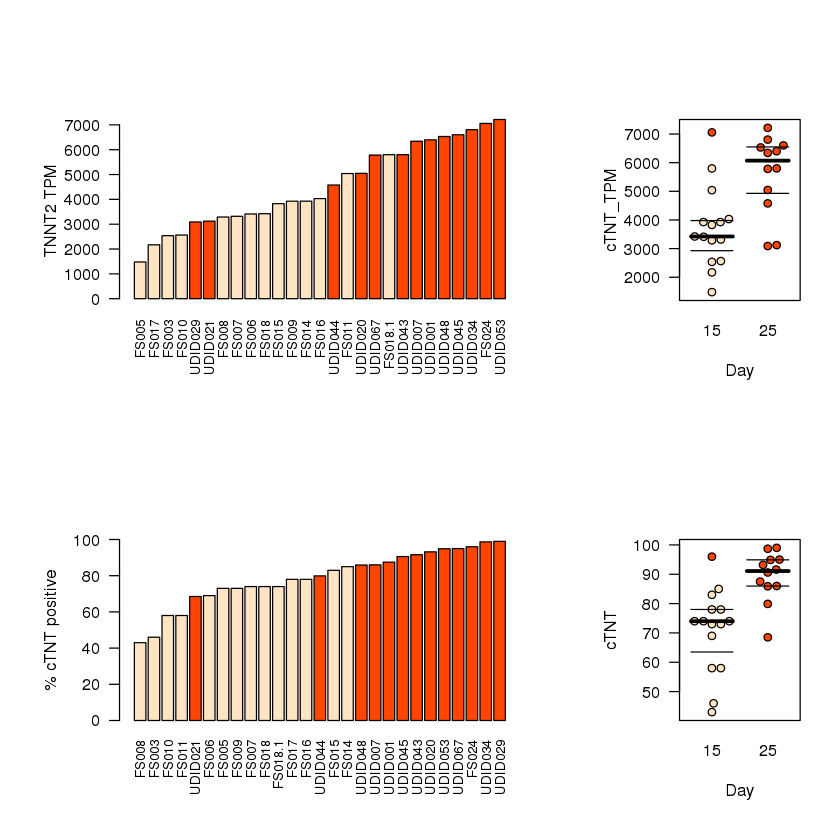

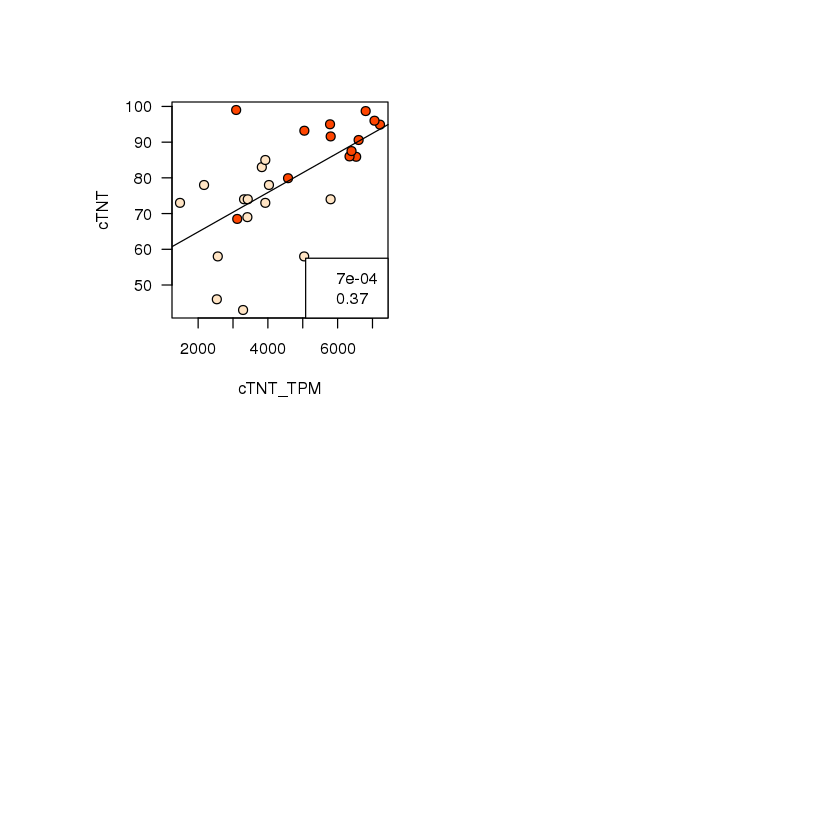

In [13]:
#pdf("../Figures/Differentiation_efficiency_comparison.pdf")
bi_colors=c("bisque", "orangered")
layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE), 
  	widths=c(2,1), heights=c(1,1))
par( mar=c(6,6,6,2))
##################
samples_cm = samples_cm[order(samples_cm$cTNT_TPM),]
color=bi_colors[as.factor(samples_cm$Lactate)]
barplot(samples_cm$cTNT_TPM, names.arg= make.unique(as.character(samples_cm$UDID)),
        las=2, col=color, cex.names=0.8, ylab="TNNT2 TPM", las=2)

beeswarm(cTNT_TPM~Day, samples_cm, 
          log = F, pch = 21, pwbg = color,corral="random", las=1)
bxplot(cTNT_TPM~Day, samples_cm, add = TRUE)
##################
samples_cm = samples_cm[order(samples_cm$cTNT),]
color=bi_colors[as.factor(samples_cm$Lactate)]

barplot(samples_cm$cTNT, names.arg= make.unique(as.character(samples_cm$UDID)),
        las=2, col=color, cex.names=0.8, ylab="% cTNT positive", ylim=c(0,100))

beeswarm(cTNT~Day, samples_cm, 
          log = F, pch = 21, pwbg = color,corral="random", las=1)
bxplot(cTNT~Day, samples_cm, add = TRUE)
##################
par( pin=c(1.8,1.8))

plot(cTNT~cTNT_TPM, samples_cm, pch = 21, bg = color, cex=1.2, las=1)
l=lm(cTNT~cTNT_TPM, samples_cm)
abline(l)
legend("bottomright", legend=c(signif(summary(l)$coefficients[2,4],2), round(summary(l)$r.squared,2) ))
##################

#dev.off()

### Perform PCA using reference samples to benchmark differentiation efficiency

In [14]:
refs<-read.table('reference_samples.txt', header=T, sep="\t")
refs= refs[16:nrow(refs),]
refs= refs[refs$Sample.name!="Aorta",]

In [15]:
refs

,Sample.ID,Sample.name,tissue
16,SRR2453359,H1-hESC,ESC
17,SRR2453365,HUES64,ESC
18,SRR2453353,iPS-20b,iPSC_r
19,SRR2453345,iPS-18,iPSC_r
20,SRR578651,Right Atrium,heart
22,SRR577591,Right Ventricle,heart
23,SRR577587,Left Ventricle,heart
24,SRR3192433,Fetal Heart,heart


In [16]:
table(samples$Cell_type)


   iPSC iPSC-CM 
     29      27 

In [17]:
info<- data.frame(ids=c(as.character(samples$UUID), as.character(refs$Sample.ID)), 
                  name=c(as.character(samples$UDID), as.character(refs$Sample.name)),
                  labels=c(rep("",nrow(samples)), as.character(refs$Sample.name)),
                    cell_type=c(as.character(samples$Cell_type_2), as.character(refs$tissue)),
                   Gen.bkg=c(as.character(samples$Subject_ID), rep("Roadmap",8)))


In [25]:
write.table(info, "1070_production_and_refs_info.txt",quote=F, row.names=T, col.names=T, sep="\t")

In [55]:
#### Normalize with vst in DEseq2

counts_raw<-subset(raw, select=as.character(info$ids)) # never forget as.character with this command
counts_tpm<-subset(tpm, select=as.character(info$ids))
counts_raw<-counts_raw[chromo %in% autoso,]
counts_tpm<-counts_tpm[chromo %in% autoso,]
## counts_raw<-subset(counts_raw, rowSums(counts_raw)>100) # one possibility
counts_raw<-subset(counts_raw, rowMeans(counts_tpm)>1)   # used possibility
dim(counts_raw)

counts<-round(counts_raw,0)
workingData<-DESeqDataSetFromMatrix(counts, info, design= ~ cell_type)
workingData<-estimateSizeFactors(workingData)
workingData<-estimateDispersions(workingData, fitType="parametric")
vst_workingData<-varianceStabilizingTransformation(workingData, blind=TRUE)

mat<-as.data.frame(assay(vst_workingData))
colnames(mat)<-as.character(info$ids)
write.table(mat, file="1070_production_and_refs_vst_counts.txt", quote=F, row.names=T, col.names=T, sep="\t")



[1] 15725    64

converting counts to integer mode
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


In [18]:
### Load normalized data for convenience
 mat<-read.table("1070_production_and_refs_vst_counts.txt", row.names=1, header=T, sep="\t", check.names=F)

In [25]:
pca <- prcomp(t(mat))
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

In [32]:
plot_pca<-function (pcx,pcy){
d <- data.frame(PC1=pca$x[,pcx], PC2=pca$x[,pcy], info)

    plot(data=d, PC2~PC1,  xlab=(paste0("PC", pcx, ":" ,round(percentVar[pcx] * 100),"% variance")),
       ylab=(paste0("PC", pcy, ":",round(percentVar[pcy] * 100),"% variance")) , 
     pch=c(rep(21,nrow(samples)), rep(23,nrow(refs)) ), 
     bg= as.character( colorcode$color[match(d$cell_type, colorcode$cell)]), 
     #bg= as.character(d$subject.color),   
          cex=1.8, las=1, xlim=c(min(d$PC1)-1, max(d$PC1)+1) , 
     
         ylim=c(min(d$PC2)-1, max(d$PC2)+1) )
grid()
text(d$PC1, d$PC2, labels=d$label, pos=c(1,3), cex=1)

}

In [33]:
colorcode = data.frame( cell = unique(info$cell_type),
                       color= c("lightsteelblue1", "bisque", "white", "orangered", 
                                "dodgerblue4", "dodgerblue", "gold" ))

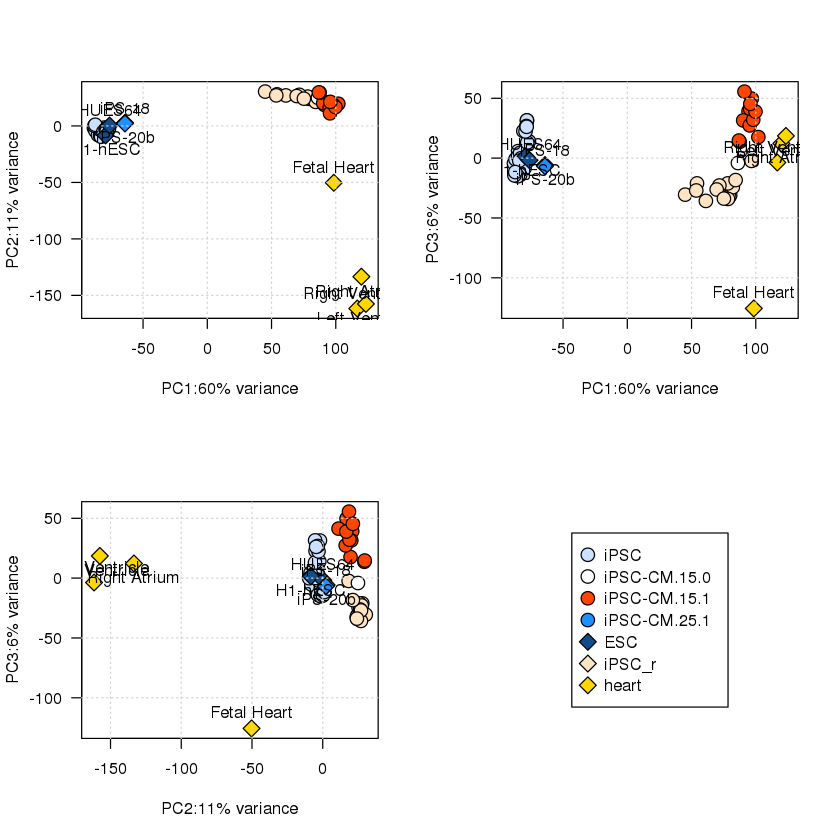

In [34]:

#pdf("../Figures/PCA_with_reference.pdf")
par(mfrow=c(2,2))
plot_pca(1,2)
plot_pca(1,3)
plot_pca(2,3)
plot.new()
legend("center", pch=c(21,21,21,21,23,23,23),cex=1,
       pt.bg=colors[as.numeric(unique(info$cell_type))], legend=unique(info$cell_type), pt.cex=1.8)

# # plot var explained
# plot(percentVar[], xlab = "Principal Component",
#              ylab = "Proportion of Variance Explained",
#              type = "b")
# #cumulative 
# plot(cumsum(percentVar[]), xlab = "Principal Component",
#               ylab = "Cumulative Proportion of Variance Explained",
#               type = "b")
# #dev.off()

### Heatmap of gene signature

In [35]:
genes=read.table("GeneList_heatmap.txt", header=T)

In [36]:
genes<-merge(genes, gene_info, by.x='Name', by.y='gene_name')
head(genes)

Name,Function,Color,Order,gene_id,gene_type,chrom,start,end,strand,gene_status,source,level
BMP2,CM.DIFF,darkorange,24,ENSG00000125845.6,protein_coding,chr20,6748310,6760927,+,KNOWN,HAVANA,2
CKM,CM.STRUCT,brown2,47,ENSG00000104879.4,protein_coding,chr19,45809671,45826235,-,KNOWN,HAVANA,2
CXCL5,STEM,cyan2,5,ENSG00000163735.6,protein_coding,chr4,74861358,74864496,-,KNOWN,HAVANA,2
DES,CM.STRUCT,brown2,48,ENSG00000175084.7,protein_coding,chr2,220283098,220291461,+,KNOWN,HAVANA,2
DKK1,CM.DIFF,darkorange,25,ENSG00000107984.5,protein_coding,chr10,54074055,54077802,+,KNOWN,HAVANA,2
DNMT3B,STEM,cyan2,6,ENSG00000088305.14,protein_coding,chr20,31350190,31397162,+,KNOWN,HAVANA,2


In [37]:
m<-merge(genes[,c("Name","gene_id")], mat, by.x=2, by.y='row.names')
rownames(m)<-m$Name
m<-m[,-c(1:2)]
colnames(m)<-make.unique(as.character(info$name))


In [38]:
################### Annotatipns ###########

genes_ann=data.frame(genes[,2])
colnames(genes_ann)="GeneFunction"
rownames(genes_ann)=genes$Name

GeneFunction     <- c("cyan2", "orange","brown")
names(GeneFunction) <- c("STEM", "CM.DIFF","CM.STRUCT")
anno_colors <- list(GeneFunction = GeneFunction)

sample_ann=info[,c("cell_type","Gen.bkg")]

colnames(sample_ann)=c("CellType", "Sample")
rownames(sample_ann)=make.unique(as.character(info$name))

CellType     <- as.character(colorcode$color)
names(CellType) <- colorcode$cell

Sample     <- c(unique(as.character(annotations$subject.color)), "gray")
names(Sample) <- c(unique(as.character(annotations$Subject_ID)), "Roadmap")


anno_colors3 <- list(CellType=CellType, Sample=Sample, GeneFunction=GeneFunction)


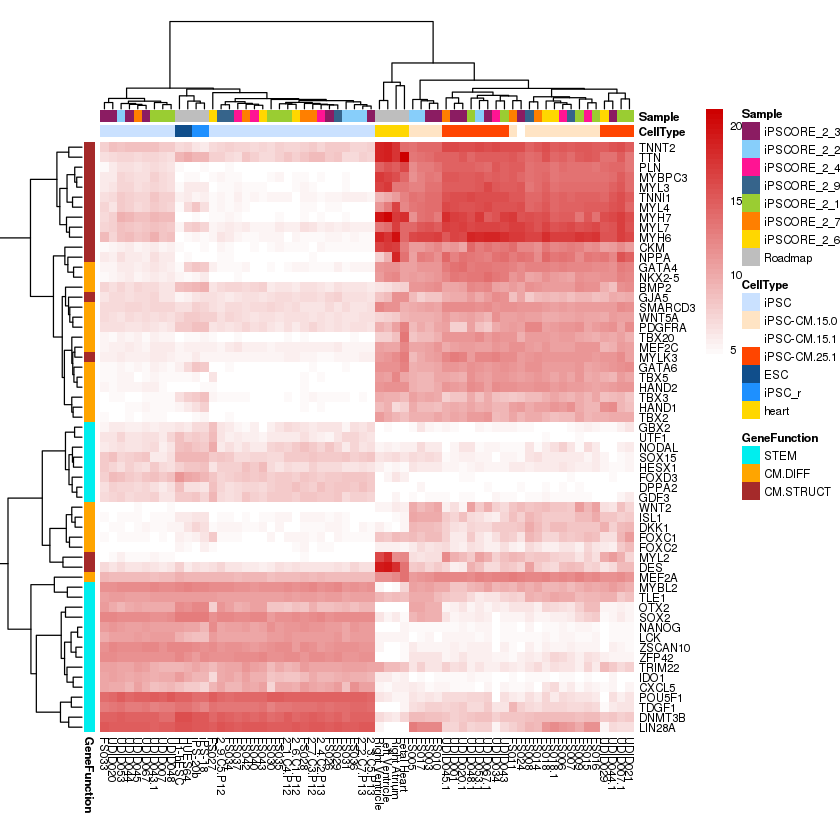

In [43]:
################### Matrix ###########

#pdf("../Figures/RNA_geneSignature_Heatmap.pdf", width=10, height=10)
color1=colorRampPalette(c( "white", "red3"))(50)
#color1=colorRampPalette(c("white", "gray10"))(50)


pheatmap(m, 
         color = color1,
         cellwidth = 5, cellheight = 6, fontsize=7, border_color=NA , show_rownames = T,
         show_colnames = T,cluster_rows = T, cluster_cols = T, 
         annotation_row=genes_ann, annotation_col=sample_ann,
         annotation_colors=anno_colors3, annotation_legend=T)


#dev.off()


## Analyze the PCs of iPSC-CM alone  

In [45]:
dir.create("iPSC_CM")

Warning message in dir.create("iPSC_CM"):
"'iPSC_CM' already exists"

In [46]:
#samples_cm<-droplevels(subset(fam, fam$Cell_type=="iPSC-CM"&fam$UUID!="0bcc0b58-b278-4fd7-9e31-19d9fa7b20f1"))
raw_counts <-subset(raw, select=as.character(samples_cm$UUID))
tpm_counts <-subset(tpm, select=as.character(samples_cm$UUID))
raw_counts <-raw_counts[chromo %in% autoso, ]
tpm_counts <-tpm_counts[chromo %in% autoso, ]

counts     <-subset(raw_counts, rowMeans(tpm_counts)>=1) 
dim(counts)

counts<-subset(counts, select=as.character(samples_cm$UUID)) ### reorder
counts<-round(counts,0)
write.table(counts, file="iPSC_CM/filtered_raw_counts.txt", quote=F, row.names=T, col.names=T, sep="\t")

workingData<-DESeqDataSetFromMatrix(counts, samples_cm, design= ~ Subject_ID)
workingData<-estimateSizeFactors(workingData)
workingData<-estimateDispersions(workingData, fitType="parametric")
vst_workingData<-varianceStabilizingTransformation(workingData, blind=TRUE)


mat_cm<-as.data.frame(assay(vst_workingData))
colnames(mat_cm)<-as.character(samples_cm$UUID)
write.table(mat_cm, file="iPSC_CM/vst_normalized_counts.txt", quote=F, row.names=T, col.names=T, sep="\t")


[1] 15167    27

converting counts to integer mode
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


In [78]:
### Load normalized data for convenience
 mat_cm<-read.table("iPSC_CM/vst_normalized_counts.txt", row.names=1, header=T, sep="\t", check.names=F)

In [71]:
#samples_cm = merge(samples_cm, subcol, by = 'Subject_ID')

In [84]:
mat_cm = subset(mat_cm, select = as.character(samples_cm$UUID))

In [85]:
pca <- prcomp(t(mat_cm))
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

In [79]:
dim(mat_cm)

[1] 15167    27

In [62]:
plot_pca2<-function (pcx,pcy,pca,percentVar,info,color, labels, pch){
d <- data.frame(PC1=pca$x[,pcx], PC2=pca$x[,pcy], info)

plot(data=d, PC2~PC1,  xlab=(paste0("PC", pcx, ":" ,round(percentVar[pcx] * 100),"% variance")),
       ylab=(paste0("PC", pcy, ":",round(percentVar[pcy] * 100),"% variance")) , 
     pch=pch, bg=color, cex=1.8, las=1, xlim=c(min(d$PC1)-1, max(d$PC1)+1) , 
     ylim=c(min(d$PC2)-1, max(d$PC2)+1) )
    text(d$PC1, d$PC2, labels=labels, pos=3, cex=0.8)
grid()
}

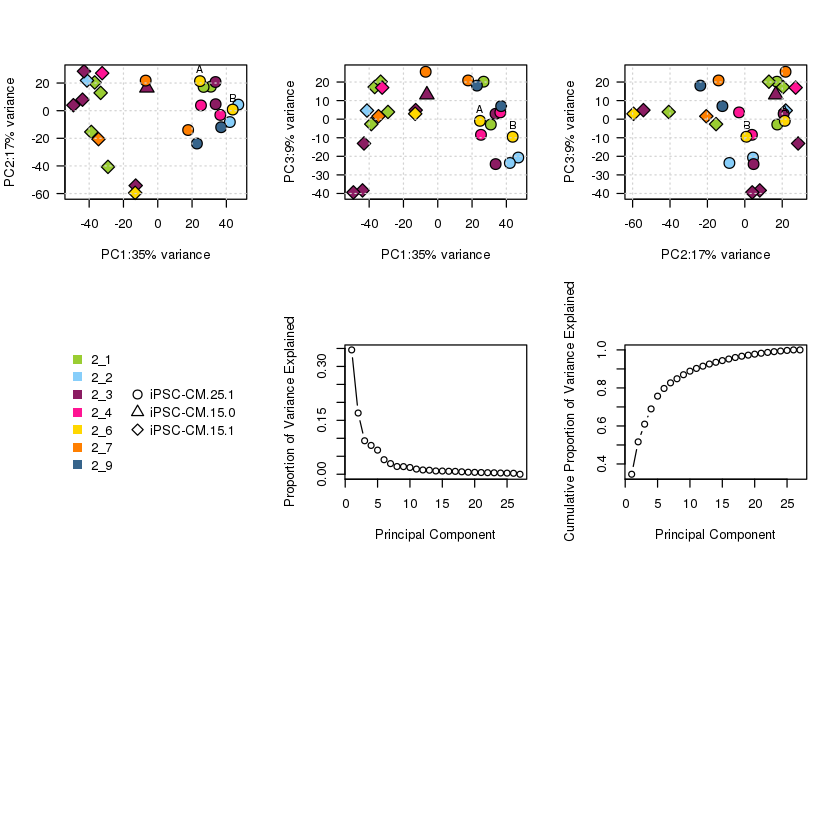

In [86]:
#pdf("iPSC_CM/PCA_cardiomyocytes.pdf")
par(mfrow=c(3,3))

plot_pca2(1,2,pca,percentVar,samples_cm, as.character(samples_cm$subject.color), 
          samples_cm$Technical_replicate_ID , c(21,24,23)[as.factor(samples_cm$Cell_type_2)] )
plot_pca2(1,3,pca,percentVar,samples_cm, as.character(samples_cm$subject.color), 
          samples_cm$Technical_replicate_ID , c(21,24,23)[as.factor(samples_cm$Cell_type_2)] )
plot_pca2(2,3,pca,percentVar,samples_cm, as.character(samples_cm$subject.color), 
          samples_cm$Technical_replicate_ID , c(21,24,23)[as.factor(samples_cm$Cell_type_2)] )
plot.new()
legend("left", pch=15,cex=1,bty = "n",
       col=unique(as.character(samples_cm$subject.color)), legend=str_split_fixed(unique(samples_cm$Subject_ID), "iPSCORE_",2)[,2], 
       pt.cex=1.5)
legend("right", pch= c(21,24,23),cex=1,bty = "n",
       legend=unique(samples_cm$Cell_type_2), pt.cex=1.5)

plot(percentVar[], xlab = "Principal Component",
             ylab = "Proportion of Variance Explained",
             type = "b")
plot(cumsum(percentVar[]), xlab = "Principal Component",
              ylab = "Cumulative Proportion of Variance Explained",
              type = "b")
#dev.off()

### Correlation of principal components with variables

In [88]:
x<-data.frame(pca$x)
rownames(x)<-samples_cm$UUID
samp_pc<- merge(samples_cm, x[,1:10], by.x="UUID", by.y="row.names")
variab<- samp_pc[, c("PC1","PC2" ,"PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
                     "cTNT", "cTNT_TPM", 'Cell_type_2', "Subject")]


In [89]:
p_val<-data.frame()
variance_expl<-data.frame()
for (i in 1:10){
    for(j in 11:ncol(variab)){
       
        l<-lm(variab[,i]~variab[,j])
        
        p_val[i,j-10]<-anova(l)[1,5]
        
        variance_expl[i,j-10]<-anova(l)[1,2]/(anova(l)[1,2]+anova(l)[2,2])
        variance_expl[i,j-10]<-summary(l)$adj.r.squared
        
        
    }
}
colnames(p_val)<-colnames(variance_expl)<-colnames(variab)[11:ncol(variab)]
rownames(p_val)<-rownames(variance_expl)<-colnames(variab)[1:10]

In [91]:
my_palette =colorRampPalette( rev(brewer.pal(9, "Blues")) )(10)[8:2]
#my_palette = colorRampPalette(c( "white","dodgerblue3"))(10)

m<--log(p_val,10)
m[m<1.3]<-NA
rownames(m)<-paste(rownames(p_val),round(percentVar[1:10],2)*100, "%" )
colnames(m)=c("TNNT2 (FACS)", "TNNT2 (RNA-Seq)", "Protocol", "Subject")
pdf("iPSC_CM/Heatmap_PC_correlations.pdf")
heatmap.2(as.matrix(m) , srtRow=0, srtCol=45, offsetRow=-0.5, offsetCol=-0.5, 
          keysize=1, margins =c(22,24), trace="none",Colv=F,Rowv=F,
          key.title="-Log10(P)", cellnote=round(variance_expl,2), notecol="black", 
          cexRow=1, cexCol=1, col=my_palette,
          sepwidth=c(0.01,0.01),sepcolor="black",colsep=0:ncol(m),rowsep=0:nrow(m))
dev.off()

Warning message in heatmap.2(as.matrix(m), srtRow = 0, srtCol = 45, offsetRow = -0.5, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(as.matrix(m), srtRow = 0, srtCol = 45, offsetRow = -0.5, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”

png 
  2

## Perform same analysis in iPSCs


In [14]:
## analysis on all iPSC - new addition
directory="iPSC_29samp"
dir.create(directory)
samples_ips<-droplevels(subset(samples, samples$Cell_type=="iPSC"))

Warning message in dir.create(directory):
"'iPSC_29samp' already exists"

In [15]:
annot = annotations[,c('Subject_ID', 'subject.color')]
annot = annot[!duplicated(annot),]
samples_ips= merge (samples_ips, annot, by="Subject_ID")

In [16]:
raw_counts <-subset(raw, select=as.character(samples_ips$UUID))
tpm_counts <-subset(tpm, select=as.character(samples_ips$UUID))
raw_counts <-raw_counts[chromo %in% autoso, ]
tpm_counts <-tpm_counts[chromo %in% autoso, ]

counts     <-subset(raw_counts, rowMeans(tpm_counts)>=1) 
dim(counts)

counts<-round(counts,0)

write.table(counts, file=paste(directory, 'filtered_raw_counts.txt', sep="/"), quote=F, row.names=T, col.names=T, sep="\t")

workingData<-DESeqDataSetFromMatrix(counts, samples_ips, design= ~ Subject_ID)
workingData<-estimateSizeFactors(workingData)
workingData<-estimateDispersions(workingData, fitType="parametric")
vst_workingData<-varianceStabilizingTransformation(workingData, blind=TRUE)

mat_ips<-as.data.frame(assay(vst_workingData))
colnames(mat_ips)<-as.character(samples_ips$UUID)
write.table(mat_ips, file=paste(directory, 'vst_normalized_counts.txt', sep="/"), quote=F, row.names=T, col.names=T, sep="\t")


[1] 14933    29

converting counts to integer mode
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


### PC plots

In [17]:
pca <- prcomp(t(mat_ips))
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )


In [19]:
pdf(paste(directory, 'PCA.pdf', sep="/"))
par(mfrow=c(3,3))

plot_pca2(1,2,pca,percentVar,samples_ips, as.character(samples_ips$subject.color), 
          samples_ips$Technical_replicate_ID , c(24,21,23)[as.factor(samples_ips$iPS_batch)] )
plot_pca2(1,3,pca,percentVar,samples_ips, as.character(samples_ips$subject.color), 
          samples_ips$Technical_replicate_ID , c(24,21,23)[as.factor(samples_ips$iPS_batch)] )
plot_pca2(2,3,pca,percentVar,samples_ips, as.character(samples_ips$subject.color), 
          samples_ips$Technical_replicate_ID , c(24,21,23)[as.factor(samples_ips$iPS_batch)] )
plot.new()
legend("left", pch=15,cex=1,bty = "n",
       col=unique(as.character(samples_ips$subject.color)), legend=str_split_fixed(unique(samples_ips$Subject_ID), "iPSCORE_",2)[,2], 
       pt.cex=1.5)
legend("right", pch= c(21,23,24),cex=1,bty = "n",
       legend=unique(samples_ips$iPS_batch), pt.cex=1.5)

plot(percentVar[], xlab = "Principal Component",
             ylab = "Proportion of Variance Explained",
             type = "b")
plot(cumsum(percentVar[]), xlab = "Principal Component",
              ylab = "Cumulative Proportion of Variance Explained",
              type = "b")
dev.off()

png 
  2

there is a batch effect in the production samples iPSC (contamination form Cms genes), also confirmed by the GO analysis and the heatmap.

### Anova of PCs with variables

In [93]:
x<-data.frame(pca$x)
rownames(x)<-samples_ips$UUID
samp_pc<- merge(samples_ips, x[,1:10], by.x="UUID", by.y="row.names")
variab<- samp_pc[, c("PC1","PC2" ,"PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
                      'iPS_batch', "Passage", "Subject")]
# variab<- samp_pc[, c("PC1","PC2" ,"PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
#                      "Passage", "Subject")]

In [94]:
p_val<-data.frame()
variance_expl<-data.frame()
for (i in 1:10){
    for(j in 11:ncol(variab)){
       
        l<-lm(variab[,i]~variab[,j])
        
        p_val[i,j-10]<-anova(l)[1,5]
        
        variance_expl[i,j-10]<-anova(l)[1,2]/(anova(l)[1,2]+anova(l)[2,2])
        variance_expl[i,j-10]<-summary(l)$adj.r.squared
        
        
    }
}
colnames(p_val)<-colnames(variance_expl)<-colnames(variab)[11:ncol(variab)]
rownames(p_val)<-rownames(variance_expl)<-colnames(variab)[1:10]

my_palette =colorRampPalette( rev(brewer.pal(9, "Blues")) )(10)[8:2]
#my_palette = colorRampPalette(c( "white","dodgerblue3"))(10)

m<--log(p_val,10)
m[m<1.3]<-NA
rownames(m)<-paste(rownames(p_val),round(percentVar[1:10],2)*100, "%" )

pdf(paste(directory, "Heatmap_PC_correlations.pdf", sep="/"))
heatmap.2(as.matrix(m) , srtRow=0, srtCol=45, offsetRow=-0.5, offsetCol=-0.5, 
          keysize=1, margins =c(22,26), trace="none",Colv=F,Rowv=F,
          key.title="-Log10(P)", cellnote=round(variance_expl,2), notecol="black", 
          cexRow=1, cexCol=1, col=my_palette,
          sepwidth=c(0.01,0.01),sepcolor="black",colsep=0:ncol(m),rowsep=0:nrow(m))
dev.off()

Warning message in heatmap.2(as.matrix(m), srtRow = 0, srtCol = 45, offsetRow = -0.5, :
"Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram."Warning message in heatmap.2(as.matrix(m), srtRow = 0, srtCol = 45, offsetRow = -0.5, :
"Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram."

png 
  2

PC1 is strongly associated with batch (index hopping issue from the production data) and also with passage, however the association with passage is dependent on batch, as the production batch as higher passage - it is better not to correct for passage

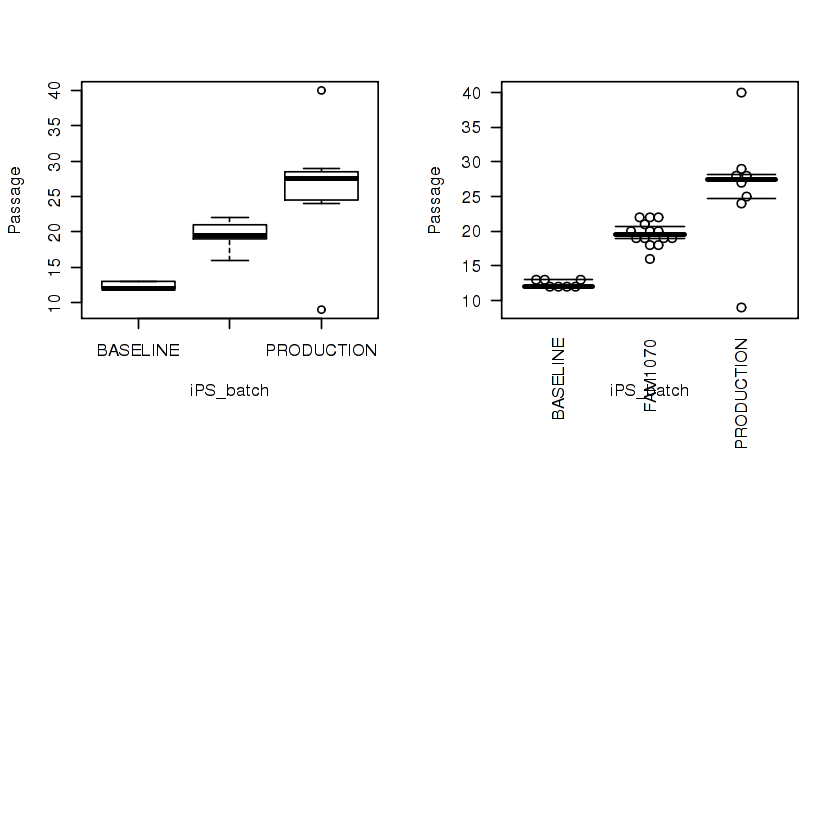

In [23]:
par(mfrow=c(2,2))
plot(Passage~iPS_batch, samples_ips)
beeswarm(Passage~iPS_batch, samples_ips, 
          log = F, pch = 21,corral="random", las=2)
bxplot(Passage~iPS_batch, samples_ips, add = TRUE)